Con este programa generamos un dataframe con datos de imagenes

In [1]:
import os

home = os.path.expanduser("~")

db_name=  'colab_main_dataset_21' #'test_new_creators_4'
#input_dir = os.path.join(home, 'video_resources', 'image_datasets')
output_dir = os.path.join(home, 'video_resources', 'sql_database')
#output_dir = os.path.join(home, 'drive', '.shared','LR_face_video')
#database_names=['enfsi','lfw','forenface'] # 'lfw', 'scface',  'enfsi', 'enfsi2015', 'xqlfw', 'utkface','chokepoint','forenface'
#detector_names=['mtcnn'] # 'dlib', 'mtcnn', 'mtcnn_serfiq'
#embedding_model_names=["QMagFace"] # , "Dlib", "ArcFace",
#attributes_to_update=[]  # 'gender', 'age', 'emotion', 'race'
#quality_model_names = ['ser_fiq', 'tface'] # 'confusion_score', 'ser_fiq',

In [2]:
from sql_face.alchemy import get_session
session = get_session(output_dir, db_name)



2023-05-27 16:23:02.636250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sql_face.tables import EnfsiPair, EnfsiPair2015, QualityImage, FaceImage, CroppedImage, Image, QualityModel, QualityGroup,Detector, EmbeddingModel,EnfsiImage,EnfsiVideoFrame

In [4]:

results = session.query(Image,Detector.name,EmbeddingModel.name,QualityModel.name,QualityImage.quality_group,QualityImage.quality) \
                        .select_from(Image) \
                        .join(CroppedImage).join(Detector).filter(CroppedImage.face_detected == True) \
                        .join(FaceImage).join(EmbeddingModel) \
                        .join(QualityImage).join(QualityModel) \
                        .filter(QualityImage.quality != None) \
                        .all() 
#.filter(EnfsiVideoFrame.yaw !=None)
#

: 

: 

In [ ]:
im_cols = ['identity', 'pitch', 'angle_pitch', 'yaw', 'angle_yaw', 'roll','angle_roll',
           'source', 'gender', 'headgear',  'age','age_number',
            'glasses', 'type',  'beard', 'emotion', 'other_occlusions',
            'race',  'image_id']


df = pd.DataFrame([ [getattr(r[0],attr)   for attr in im_cols]  + list(r[1:6])
                   for r in results],
                   columns=im_cols + ['Detector','E_Model','Q_model','Q_group','Quality']  )

df.to_pickle(os.path.join(output_dir,'df_all_colab_21.pkl'))

<AxesSubplot: >

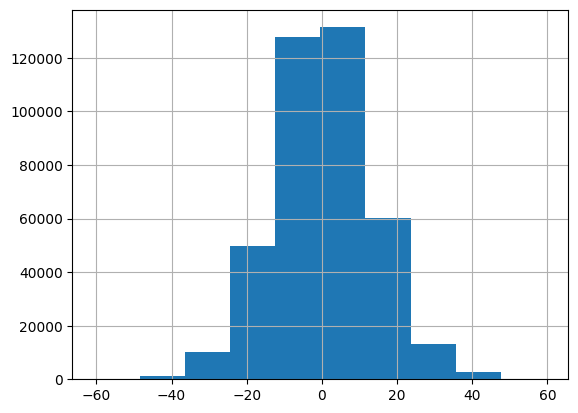

In [ ]:
df.angle_yaw.hist()

In [ ]:
df.source.value_counts()

LFW          396760
XQLFW        333030
SCFace       111150
ForenFace     69118
ENFSI         16630
Name: source, dtype: int64

In [ ]:
len(results)

926688

In [ ]:
df